In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import sys
sys.path.append('../')
from pysktb import Atom,Structure,System,Hamiltonian,Lattice

# sp chain in a lattice for SSH model


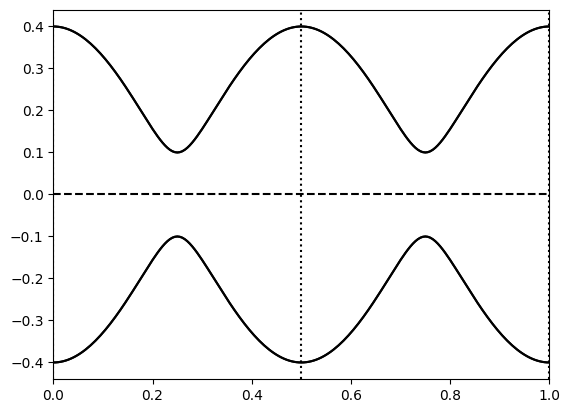

In [5]:
from pysktb import *
a=Atom("a",[0,0,0])
a.set_orbitals(["s","px"])
atoms=[a]
lattice=Lattice([[1,0,0],[0,10,0],[0,0,10]],1)
sk={"a":{"e_p":0
         ,"e_s":0},
    "aa":{"V_sss":-.2,
          "V_sps":-.05,
          "V_pps":0.2}}
bond={"aa":{"NN":1.2}}

s=Structure(lattice,atoms,bond_cut=bond)

ham1=Hamiltonian(s,sk)

path=[[0.5, 0.0, 0.0], [0.0, 0.0, 0.0], [-.5, 0.0, -0.0]]

k_path, k_dist,k_pts=ham1.get_kpts(path,100)
eigs_k = []


evals=ham1.solve_kpath(k_path)

fig,ax=plt.subplots()
for i in evals:ax.plot(k_dist,i,c="k")
for i in k_pts:ax.axvline(i,c="k",ls=":")
ax.axhline(0,c="k",ls="--")
ax.set_xlim(k_pts.min(),k_pts.max())
plt.savefig("sp-chain.png")
plt.show()


### total energy
for semimetals and insulators, total energy can be calculated

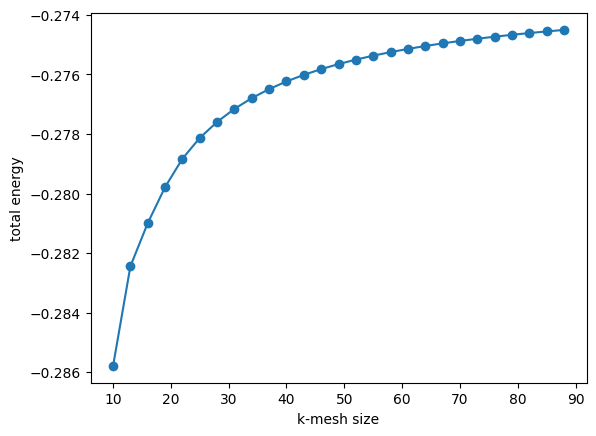

In [6]:
energies=[]
nk=range(10,90,3)
for i in nk:
    energies.append(ham1.total_energy(nk=i,dim=1)) #nk mesh points and dimension = 1
plt.plot(nk,energies,marker="o")
plt.xlabel("k-mesh size")
plt.ylabel("total energy")
plt.savefig("sp-chain-total_energy.png")

### We can project it on to each orbitals
Hameltonian always counts for spin and hence we have 4x4 system even though we have 2 orbitals (this is to save time on the fly for SOC)

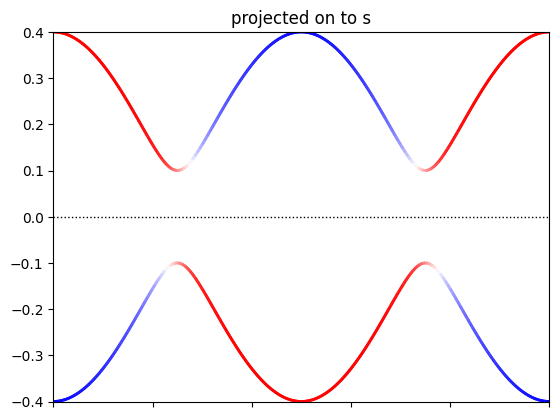

In [7]:
evals,vecs=ham1.solve_kpath(k_path, eig_vectors=True)
fig,ax=plt.subplots()
ham1.plot_kproj(evals,vecs,k_dist,index=[0,1],ax=ax)
ax.set_xticklabels([""])
ax.set_title("projected on to s")
plt.savefig("sp-chain-proj.png")
plt.show()

## DOS

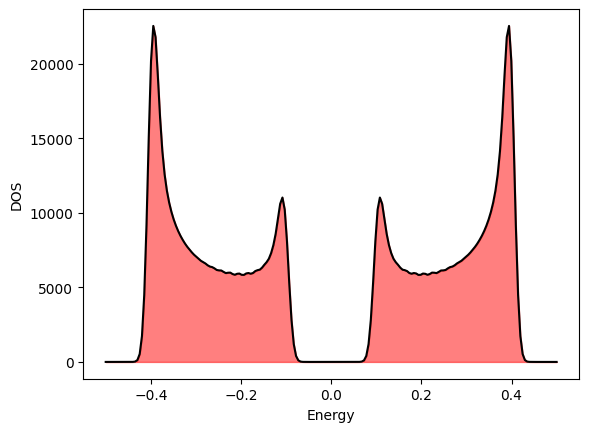

In [8]:
energy=np.linspace(-.5,.5,200)
dos=ham1.get_dos(energy,nk=[50,50,1],w=1e-2)
fig,ax=plt.subplots()
ax.plot(energy,dos,c="k")
ax.fill_between(energy, dos, color='red',alpha=.5)
ax.set_ylabel("DOS")
ax.set_xlabel("Energy")
plt.savefig("sp-chain-dos.png")
plt.show()

# Graphene

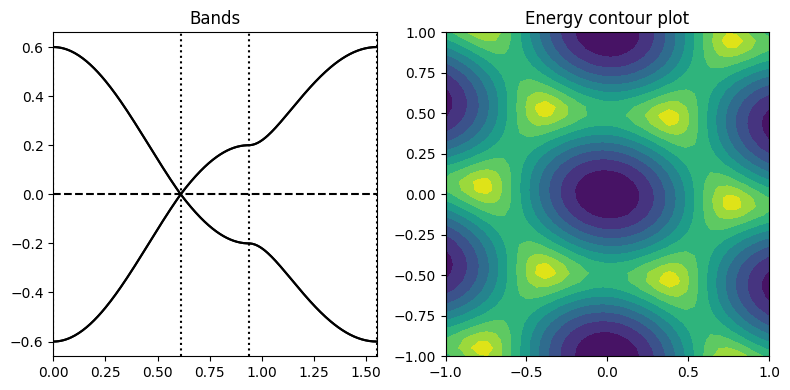

In [9]:
a=Atom("C",[1./3.,1./3.,0])
b=Atom("C",[2./3.,2./3.,0])
atoms=[a,b]
for i in atoms:
    i.set_orbitals(["pz"])
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10]],1)

# SK interaction values 
interactions={"C":{"e_p":0}
    ,"CC":{"V_ppp":.2}}

bond={"CC":{"NN":.8}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals=ham.solve_kpath(k_path)


fig,ax=plt.subplots(1,2,figsize=(8,4))
for i in evals:ax[0].plot(k_dist,i,c="k")
for i in k_pts:ax[0].axvline(i,c="k",ls=":")
ax[0].axhline(0,c="k",ls="--")
ax[0].set_xlim(k_pts.min(),k_pts.max())
ax[0].set_title("Bands")

e=[]
for i in np.linspace(-1,1,40):
    for j in np.linspace(-1,1,40):
        k=ham.k_red2cart([i,j,0])
        evals=ham.solve_k(k)
        e.append(evals)
ax[1].contourf(np.linspace(-1,1,40),np.linspace(-1,1,40),
               np.array(e).reshape(40,40,-1)[:,:,0],10)
ax[1].set_title("Energy contour plot")
plt.tight_layout()
plt.savefig("graphene.png")
plt.show()

## Interfaceing cif file structure using pymatgen with ham
### need to write helper modules to use pymatgen/ase to make it easy

Also shown how to include SOC

In [14]:
from pymatgen.core import Structure as pymatgen_structure
from pymatgen.core import surface
C=pymatgen_structure.from_file("c.cif")
# make a finite nano ribbon
C_copy=C.copy()
C_copy.make_supercell([[1,0,0],[0,1,0],[0,0,1]])
[zigzag,bearded]=surface.SlabGenerator(C_copy,miller_index=[1,0,0]
                             ,min_slab_size=18,
                             min_vacuum_size=3).get_slabs()#[1]#.to("cif","finite.cif"))

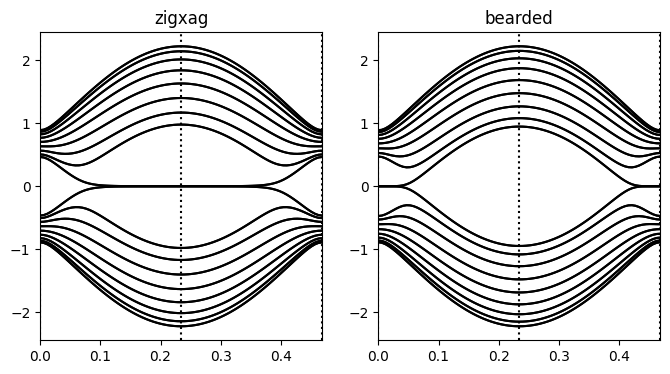

In [18]:
def bands_from_pymatgen(struc,ax):
    atoms=[]
    for i in struc:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["pz"])

    d=0
    lattice=Lattice(struc.lattice.matrix,1)
    interactions={"C":{"e_p":0}
        ,"CC":{"V_ppp":-.9,"V_pps":1.2}}


    nn=np.unique(np.sort(struc.distance_matrix.flatten()))[1]
    bond={"CC":{"NN":nn+.5}}


    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions)

    path=[[0.,0.,0],[0.5,0,0],[1,0,0]]
    k_path, k_dist,k_pts=ham.get_kpts(path,40)

    eigs_k = []
    evals=ham.solve_kpath(k_path)

    for i in evals:ax.plot(k_dist,i,c="k")
    for i in k_pts:ax.axvline(i,c="k",ls=":")
    ax.set_xlim(k_pts.min(),k_pts.max())

fig,ax=plt.subplots(1,2,figsize=(8,4))
bands_from_pymatgen(zigzag,ax[0])
bands_from_pymatgen(bearded,ax[1])
title=["zigxag","bearded"]
for j,i in enumerate(ax):i.set_title(title[j])
plt.savefig("graphene-Edge-states.png")

In [20]:

from pymatgen.core import Structure as pymatgen_structure
C=pymatgen_structure.from_file("c.cif")

atoms=[]

# Need to consider px-py-pz for SOC effect as of now. 
for i in C:
    atoms.append(Atom(i.species_string,i.frac_coords))
for i in atoms:
    i.set_orbitals(["px","py","pz"])

#set py,pz levels different to not deentangle from pz of our system and include SOC
d=3
lattice=Lattice(C.lattice.matrix,1)
interactions={"C":{"e_p":[-d,-d,d],"lambda":1.5}
    ,"CC":{"V_ppp":-.2,"V_pps":1.2}}

# minimum distance neibghor
nn=np.unique(np.sort(C.distance_matrix.flatten()))[1]
bond={"CC":{"NN":nn+.5}}


s=Structure(lattice,atoms,bond_cut=bond)

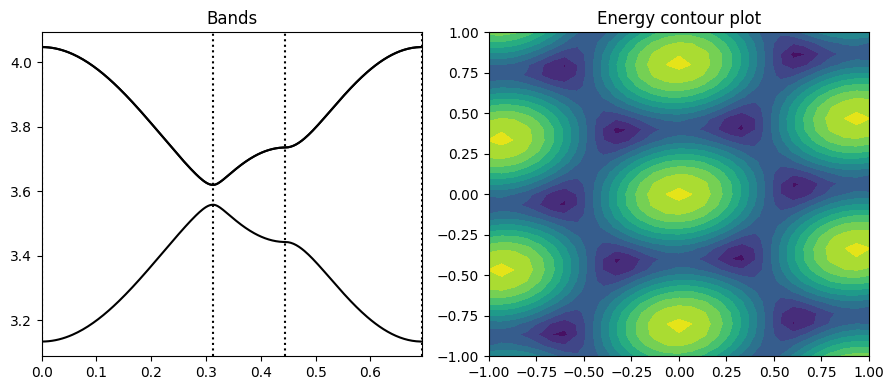

In [21]:

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[1./3.,-2./3.,0],[0.5,-0.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals=ham.solve_kpath(k_path)

#plot just pz bands

fig,ax=plt.subplots(1,2,figsize=(9,4))
for i in evals[-3:]:ax[0].plot(k_dist,i,c="k")
for i in k_pts:ax[0].axvline(i,c="k",ls=":")
#ax[0].axhline(0,c="k",ls="--")
ax[0].set_xlim(k_pts.min(),k_pts.max())
ax[0].set_title("Bands")

e=[]
nk=31
for i in np.linspace(-.5,.5,nk):
    for j in np.linspace(-.5,.5,nk):
        k=ham.k_red2cart([i,j,0])
        k=ham.k_red2cart([i,j,0])
        evals=ham.solve_k(k)
        e.append(evals)
ax[1].contourf(np.linspace(-1,1,nk),np.linspace(-1,1,nk),
               np.array(e).reshape(nk,nk,-1)[:,:,-1],10)
ax[1].set_title("Energy contour plot")
plt.tight_layout()
plt.show()

## Rashba SOC in Metal Halide Perovskites

Example of tuning SOC to see the Rashba effect in Halide perovskite
https://www.nature.com/articles/s41467-018-04212-w.pdf


In [4]:
import pymatgen as pymat
p=pymat.Structure.from_file("Cssii2.cif") 
def get_ham(soc=0.3):
    atoms=[]
    for i in p[1:]:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["px","py","pz"])
    atoms[0].set_orbitals(["s","px","py","pz"])
    lattice=Lattice(p.lattice.matrix,1)
    d=.8
    interactions={  "Si":{"e_s":d,"e_p":[d,d,d],"lambda":soc}
                    ,"I":{"e_p":[-d,-d,-d]}
                    ,"SiI":{"V_sps":1,"V_ppp":-.5,"V_pps":2}
                    ,"II":{"V_ppp":0,"V_pps":0}
                    ,"SiSi":{"V_ppp":0,"V_pps":0}}
    nn=p.get_distance(1,2)
    bond={"SiI":{"NN":nn+1}
         ,"II":{"NN":nn+1.2}
         ,"SiSi":{"NN":nn+1}}
    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions,numba=1)
    return ham


#### Basic band structure with orbitrals projected on Iodine for CsBrI$_3$

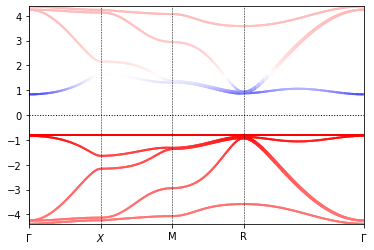

In [7]:
ham=get_ham(soc=0.0)

path=[[0.,0.,0],[0.5,0,0],[0.5,.5,0],[0,0,0],[.5,.5,.5],[0,.5,0]]
X=[0.5,0,0]
G=[0,0,0]
M=[.5,.5,0]
R=[.5,.5,.5]
label=["$\Gamma$","$X$","M","R","$\Gamma$"]
orbs=ham.orbital_order
path=[G,X,M,R,G]

k_path, k_dist,k_pts=ham.get_kpts(path,30)
evals,vecs=ham.solve_kpath(k_path, eig_vectors=True)
fig,ax=plt.subplots()
index=[i for i in orbs if "I" in orbs[i]]
ham.plot_kproj(evals,vecs,k_dist,index=index,ax=ax)
ax.set_xticks(k_pts)
ax.set_xticklabels(label)
for i in k_pts:ax.axvline(i,c="k",ls="--",lw=.5)
plt.show()

Effect of adding SOC 

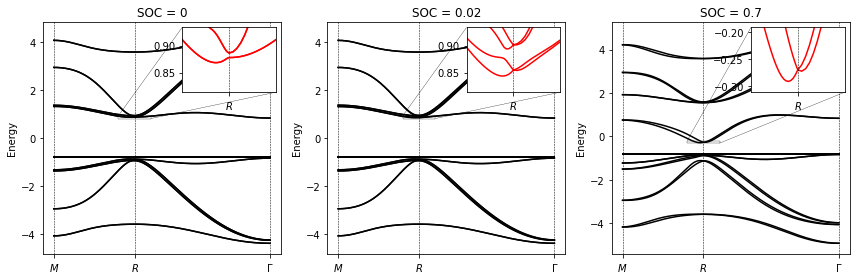

In [10]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

SOC=[0,.02,.7]
fig,ax1=plt.subplots(1,len(SOC),figsize=(len(SOC)*4,4))
for i,j in enumerate(SOC):
    ham=get_ham(soc=j)
    path=[M,R,G]
    label=["$M$","$R$","$\Gamma$"]
    k_path, k_dist,k_pts=ham.get_kpts(path,100)
    evals,vecs=ham.solve_kpath(k_path, eig_vectors=True)
    
    #----plotting
    ax=ax1[i]
    for i in evals:ax.plot(k_dist,i,c="k")
    ax.set_xticks(k_pts)
    ax.set_xticklabels(label)
    for i in k_pts:ax.axvline(i,c="k",ls="--",lw=.5)
    ax.set_ylabel("Energy")
    ax.set_title("SOC = {}".format(j))
    
    #----plot inset
    ax_in= inset_axes(ax, width=1.3, height=0.9)
    mark_inset(ax, ax_in, loc1=4, loc2=2, fc="none", lw=.3, ec='k')
    for i in evals:ax_in.plot(k_dist,i,c="r")
    ax_in.set_xticks(k_pts)
    ax_in.set_xticklabels(label)
    for i in k_pts:
        ax_in.axvline(i,c="k",ls="--",lw=.5)
    ax_in.set_ylim([evals[18].min()-.02,evals[18].min()+.1])
    ax_in.set_xlim(k_pts[1]*.8,k_pts[1]*1.2)
plt.tight_layout()
plt.savefig("Perovskite_soc.png",dpi=500)
plt.show()

# buckled Sb Monolayer
## arXiv:1912.03755 

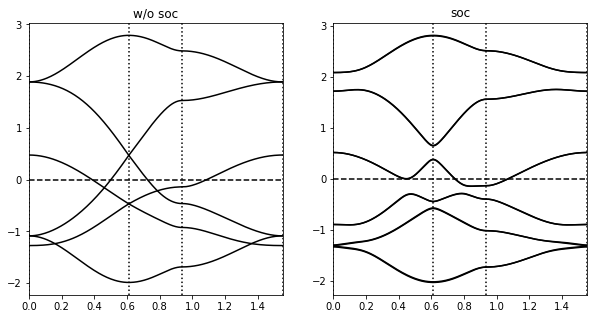

In [9]:
theta=np.deg2rad(1.2)
h=np.sin(theta)*np.cos(theta)
a=Atom("a",[1./3.,1./3.,2+h/10])
a.set_orbitals(["px","py","pz"])
b=Atom("b",[2./3.,2./3.,2-h/10])
b.set_orbitals(["px","py","pz"])
atoms=[a,b]
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10/np.cos(theta)]],np.cos(theta))

# SK interaction values 
d=0.4
interactions={"a":{"e_p":[d,d,-d],"lambda":0.19}
    ,"b":{"e_p":[d,d,-d],"lambda":0.2},
    "ab":{"V_ppp":-0.3,"V_pps":1.3},
    "bb":{"V_ppp":0,"V_pps":0},
    "aa":{"V_ppp":0,"V_pps":0.}}

#NN distance for each pair
bond={"ab":{"NN":1},
      "aa":{"NN":0},
      "bb":{"NN":0}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals_soc = []
evals = []
for kpt in k_path:
        H = ham.get_ham(np.array(kpt))
        eigs = np.linalg.eigvalsh(H)
        evals_soc.append(eigs)
        
        H = ham.get_ham(np.array(kpt),l_soc=False)
        eigs = np.linalg.eigvalsh(H)
        evals.append(eigs)

evals = np.array(evals).T
evals_soc = np.array(evals_soc).T

fig,ax=plt.subplots(1,2,figsize=(10,5))
for axis in range(2):
    if axis==0:
        e=evals;title="w/o soc"
    else:e=evals_soc;title="soc"
    for i in e:ax[axis].plot(k_dist,i,c="k")
    for i in k_pts:ax[axis].axvline(i,c="k",ls=":")
    ax[axis].axhline(0,c="k",ls="--")
    ax[axis].set_xlim(k_pts.min(),k_pts.max())
    ax[axis].set_title(title)
plt.savefig("Sb-flat.png")
plt.show()

### SOC spin split in low buckled Group -V system 
#### projected on to Sz component 

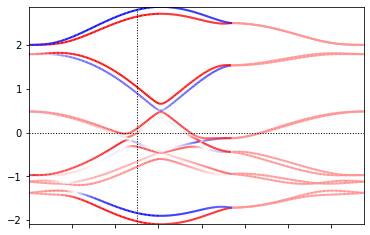

In [48]:
theta=np.deg2rad(1.2)
h=np.sin(theta)*np.cos(theta)
a=Atom("a",[1./3.,1./3.,2+h/10])
a.set_orbitals(["px","py","pz"])
b=Atom("b",[2./3.,2./3.,2-h/10])
b.set_orbitals(["px","py","pz"])
atoms=[a,b]
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10/np.cos(theta)]],np.cos(theta))

# SK interaction values 
d=0.4
interactions={"a":{"e_p":[d,d,-d],"lambda":0.03}
    ,"b":{"e_p":[d,d,-d],"lambda":0.2},
    "ab":{"V_ppp":-0.3,"V_pps":1.3},
    "bb":{"V_ppp":0,"V_pps":0},
    "aa":{"V_ppp":0,"V_pps":0.}}

#NN distance for each pair
bond={"ab":{"NN":1},
      "aa":{"NN":0},
      "bb":{"NN":0}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals,vecs=ham.solve_kpath(k_path, eig_vectors=True)
fig,ax=plt.subplots()
ham1.plot_kproj(evals,vecs,k_dist,index=np.arange(11)[::2],ax=ax,cmap="bwr")
ax.set_xticklabels([""])
plt.show()

## Group V -  Fully buckled case HOTI
### Higher Order Topological Insulators

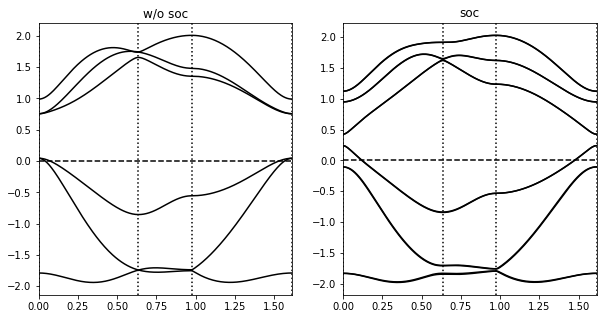

In [10]:
theta=np.deg2rad(16)
h=np.sin(theta)*np.cos(theta)
a=Atom("a",[1./3.,1./3.,2+h/10])
a.set_orbitals(["px","py","pz"])
b=Atom("b",[2./3.,2./3.,2-h/10])
b.set_orbitals(["px","py","pz"])
atoms=[a,b]
# lattice(plat,alat)
lattice=Lattice([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10/np.cos(theta)]],np.cos(theta))

# SK interaction values 
d=0.4
interactions={"a":{"e_p":[d,d,-d],"lambda":0.19}
    ,"b":{"e_p":[d,d,-d],"lambda":0.2},
    "ab":{"V_ppp":-0.3,"V_pps":1.3},
    "bb":{"V_ppp":0,"V_pps":0},
    "aa":{"V_ppp":0,"V_pps":0.}}

#NN distance for each pair
bond={"ab":{"NN":1},
      "aa":{"NN":0},
      "bb":{"NN":0}}

# defining the structure class
s=Structure(lattice,atoms,bond_cut=bond)

# defining the hameltonian with interactions
ham=Hamiltonian(s,interactions)


# solve it along a path

path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,100)

evals_soc = []
evals = []
for kpt in k_path:
        H = ham.get_ham(np.array(kpt))
        eigs = np.linalg.eigvalsh(H)
        evals_soc.append(eigs)
        
        H = ham.get_ham(np.array(kpt),l_soc=False)
        eigs = np.linalg.eigvalsh(H)
        evals.append(eigs)

evals = np.array(evals).T
evals_soc = np.array(evals_soc).T

fig,ax=plt.subplots(1,2,figsize=(10,5))
for axis in range(2):
    if axis==0:
        e=evals;title="w/o soc"
    else:e=evals_soc;title="soc"
    for i in e:ax[axis].plot(k_dist,i,c="k")
    for i in k_pts:ax[axis].axvline(i,c="k",ls=":")
    ax[axis].axhline(0,c="k",ls="--")
    ax[axis].set_xlim(k_pts.min(),k_pts.max())
    ax[axis].set_title(title)
plt.savefig("Sb_buckled.png")
plt.show()

## SOC and TCI edge states in low buckled Sb

In [5]:
C=p.Structure.from_file("c.cif")
C_copy=C.copy()
C_copy.replace(0, "C", C_copy[0].coords+[0,0,.1], coords_are_cartesian=True, properties=None)
C_copy.make_supercell([[1,0,0],[0,1,0],[0,0,1]])
[zigzag,bearded]=p.core.surface.SlabGenerator(C_copy,miller_index=[1,0,0]
                             ,min_slab_size=60,
                             min_vacuum_size=3).get_slabs()

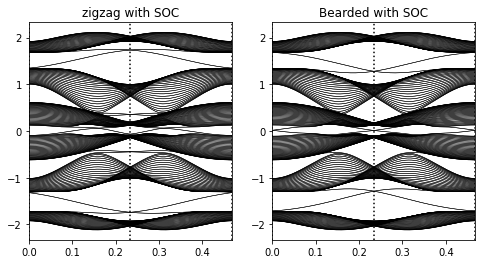

In [6]:
def bands_from_pymatgen(struc,ax,ham_ret=0):
    atoms=[]
    for i in struc:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["px","py","pz"])

    d=0
    lattice=Lattice(struc.lattice.matrix,1)
    interactions={"C":{"e_p":[d,d,-d],"lambda":0.2}
        ,"CC":{"V_ppp":-.2,"V_pps":1.2}}


    nn=np.unique(np.sort(struc.distance_matrix.flatten()))[1]
    bond={"CC":{"NN":nn+.5}}


    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions,numba=1)
    path=[[0.,0.,0],[0.5,0,0],[1,0,0]]
    k_path, k_dist,k_pts=ham.get_kpts(path,100)
    evals,evecs=ham.solve_kpath(k_path,eig_vectors=True)
    for i in evals:ax.plot(k_dist,i,c="k",lw=.5)
    for i in k_pts:ax.axvline(i,c="k",ls=":")
    ax.set_xlim(k_pts.min(),k_pts.max())
    #ax.set_ylim([-.2,.2])
    if ham_ret: return ham
fig,ax=plt.subplots(1,2,figsize=(8,4))
bands_from_pymatgen(zigzag,ax[0])
ax[0].set_title("zigzag with SOC")
bands_from_pymatgen(bearded,ax[1])
ax[1].set_title("Bearded with SOC")
plt.savefig("buckled_sb_SOC.png",dpi=600)
plt.show()

# Optimization tests

## Parallel test

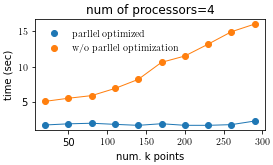

In [4]:
from pysktb import *
import pymatgen as p
struc=p.Structure.from_file("c.cif")
struc.make_supercell([[20,0,0],[0,1,0],[0,0,1]])
def time_test_parallel(struc,parallel=1,nk=100):  
    atoms=[]
    for i in struc:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["px","py","pz"])

    d=0
    lattice=Lattice(struc.lattice.matrix,1)
    interactions={"C":{"e_p":[d,d,-d],"lambda":0.2}
        ,"CC":{"V_ppp":-.2,"V_pps":1.2}}


    nn=np.unique(np.sort(struc.distance_matrix.flatten()))[1]
    bond={"CC":{"NN":nn+.5}}


    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions)
    path=[[0.,0.,0],[0.5,0,0],[1,0,0]]
    k_path, k_dist,k_pts=ham.get_kpts(path,nk)
    ham.solve_kpath(k_path,eig_vectors=True,parallel=parallel)
    return None
import time
nk=np.arange(20,300,30)
parl_time=[]
no_parl_time=[]
for i in nk:
    start = time.time()
    time_test_parallel(struc,0,i)
    end = time.time()
    no_parl_time.append(end - start)
    start = time.time()
    time_test_parallel(struc,i,1)
    end = time.time()
    parl_time.append(end - start)
    
####---- plot
fig,ax=plt.subplots(figsize=(4,2.5))
plt.style.use(["default","science"])
ax.scatter(nk,parl_time,label="parllel optimized")
ax.scatter(nk,no_parl_time,label="w/o parllel optimization")
ax.plot(nk,parl_time)
ax.plot(nk,no_parl_time)
ax.set_xlabel("num. k points")
ax.set_ylabel("time (sec)")
ax.set_title("num of processors=4")
plt.legend()
plt.tight_layout()
plt.savefig("pysktb_parallel.png",dpi=600)
plt.show()

## JIT optimization test

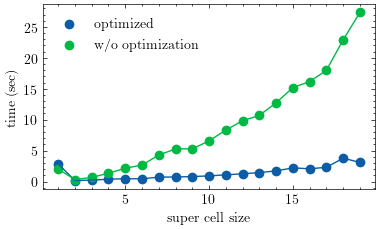

In [5]:
def time_test(n=1,numba=1):
    struc=p.Structure.from_file("c.cif")
    struc.make_supercell([[n,0,0],[0,1,0],[0,0,1]])
    atoms=[]
    for i in struc:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["px","py","pz"])

    d=0
    lattice=Lattice(struc.lattice.matrix,1)
    interactions={"C":{"e_p":[d,d,-d],"lambda":0.2}
        ,"CC":{"V_ppp":-.2,"V_pps":1.2}}


    nn=np.unique(np.sort(struc.distance_matrix.flatten()))[1]
    bond={"CC":{"NN":nn+.5}}


    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions,numba=numba)
    path=[[0.,0.,0],[0.5,0,0],[1,0,0]]
    k_path, k_dist,k_pts=ham.get_kpts(path,40)
    evals,evecs=ham.solve_kpath(k_path,eig_vectors=True)

import time
atoms=np.arange(1,20)
numba_time=[]
no_numba_time=[]
for i in atoms:
    start = time.time()
    time_test(i,0)
    end = time.time()
    no_numba_time.append(end - start)
    start = time.time()
    time_test(i,1)
    end = time.time()
    numba_time.append(end - start)

fig,ax=plt.subplots(figsize=(4,2.5))
plt.style.use(["default","science"])
ax.scatter(atoms,numba_time,label="optimized")
ax.scatter(atoms,no_numba_time,label="w/o optimization")
ax.plot(atoms,numba_time)
ax.plot(atoms,no_numba_time)
ax.set_xlabel("super cell size")
ax.set_ylabel("time (sec)")
plt.legend()
plt.tight_layout()
plt.savefig("pysktb_numba.png",dpi=600)
plt.show()